# 30分足におけるN足以内に価格がX以上上昇する確率

## 目的
- ランダムに仕掛けた場合の、保有期間と損益の関係を明らかにすること
    - これをベースとして、これよりも総損益が大きくなる買い仕掛けを発見すればよい
    - もしランダム仕掛けでも総損益がプラスなら、それをそのまま使う方法もある

## 目標
- N足以内に価格がX以上上昇する確率を明らかにすること

## 仮説
1. Nが大きいほどN足以内に価格がX以上上昇する確率は高くなる
2. Xが小さいほどN足以内に価格がX以上上昇する確率は高くなる

## 分析内容
- N足以内に価格がX以上上昇する確率のグラフを描く
    - 横軸にN、縦軸に確率をとる
    - X=1, 5, 10, 15, 20の5条件

## 結果・考察
- 仮説１と仮説２はどちらも支持された。
- コストを\\$4と仮定すれば、\\$5以上つまり1ティック動いたときに手仕舞えば利益がでる。
    - この場合、ランダムな仕掛けでも16時間以上保有すれば勝率は90%を超えることになる。
- 1トレード当たりの利益が\\$1だと小さすぎて損失が出たときにそれまでの利益の大部分がパーになる可能性があるため、もっと高い目標価格を置く必要がある。
    - 32時間保有すれば目標価格がプラス5ティックでも勝率は70%を超える
    - 64時間保有すれば目標価格がプラス10ティックでも勝率は60%を超える

In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale
from joblib import Parallel, delayed
from functools import reduce

import finalib as fl
import finalib.mine as mi
import ta

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# データ読み込み

In [2]:
# 生データ
sp_dir = 'data/e-mini-sp500-200530'
df_sp_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-30min.csv')

# 分析用データ作成

In [4]:
df = df_sp_raw.copy()

# DateTime列を追加
df['DT'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))

# 1997と2020はデータが不十分のため除く
df = df[(df['DT']>dt.datetime(1998,1,1)) & (df['DT']<dt.datetime(2020,1,1))]
df = df.reset_index(drop=True)

# 年の列を追加
df['year'] = df['DT'].map(lambda d: d.year)

# 年の順序付け
year_type = CategoricalDtype(categories=range(df['year'].min(), df['year'].max()+1), ordered=True)
df['year'] = df['year'].astype(year_type)

In [51]:
def _price_range_in_n_periods(df, periods, x_price):
    dfs = []
    for p in periods:
        df_tmp = fl.make_nbars_future(df, p-1, cols=['Close', 'High', 'Low'])
        df_tmp['HODiff'] = df_tmp[[f'High{i}' for i in range(p)]].max(axis=1) - df_tmp['Open']
        df_tmp['isUpX'] = df_tmp['HODiff'] >= x_price
        df_tmp['LODiff'] = df_tmp[[f'Low{i}' for i in range(p)]].min(axis=1) - df_tmp['Open']
        df_tmp['isDownX'] = df_tmp['LODiff'] <= -x_price
        df_tmp['period'] = p
        df_tmp = df_tmp[['isUpX', 'isDownX', 'period']]
        dfs.append(df_tmp)

    return pd.concat(dfs)

def price_range_in_n_periods(df, periods, x_price):
    dft = df.copy()
    if not all([isinstance(v, int) and v > 0 for v in periods]):
        raise ValueError('all elements of periods ({periods}) must be positive int')

    dftp = _price_range_in_n_periods(dft, [v for v in periods if v != 1], x_price)

    if 1 in periods:
        periods = [v for v in periods if v != 1]
        # period = 1
        dft['HODiff'] = dft['High'] - dft['Open']
        dft['isUpX'] = dft['HODiff'] >= x_price
        dft['LODiff'] = dft['Low'] - dft['Open']
        dft['isDownX'] = dft['LODiff'] <= -x_price
        dft1 = dft[['isUpX', 'isDownX']]
        dft1['period'] = 1
        dftp = pd.concat([dft1, dftp])

    return dftp

In [98]:
periods = [1, 2, 4, 8, 16, 32, 64, 128]
x_prices = [1, 5, 10, 15, 20]


dfs = []
for x_price in x_prices:
    df_x_up_tmp = price_range_in_n_periods(df, periods, x_price)
    df_x_up_tmp['x'] = x_price
    dfs.append(df_x_up_tmp)

x_up_df = pd.concat(dfs)
x_up_df = x_up_df.reset_index(drop=True)

<ipython-input-51-8dd437583f65>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft1['period'] = 1
<ipython-input-51-8dd437583f65>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft1['period'] = 1
<ipython-input-51-8dd437583f65>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [99]:
x_up_data = x_up_df.groupby(['period','x'])['isUpX'].value_counts()
x_up_data = x_up_data / df.shape[0]

In [100]:
x_up_data

period  x   isUpX
1       1   False    0.524722
            True     0.475278
        5   False    0.952446
            True     0.047554
        10  False    0.992436
                       ...   
128     10  False    0.360734
        15  False    0.527059
            True     0.472418
        20  False    0.657129
            True     0.342348
Name: isUpX, Length: 80, dtype: float64

In [101]:
# periodを30分単位から1時間単位に変換
x_up_data.index = x_up_data.index.map(lambda x: (x[0]/2, x[1], x[2]))

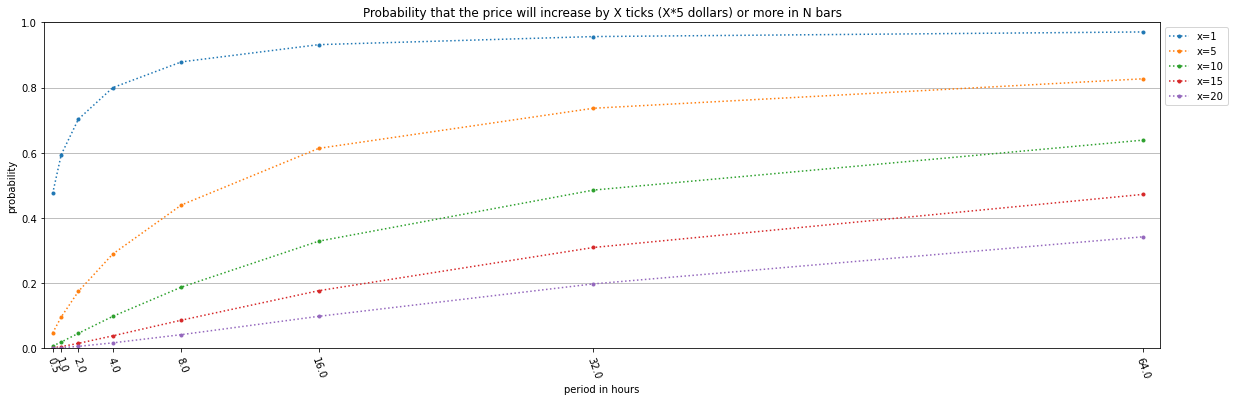

In [126]:
plt.figure(figsize=(20,6))
colors = [f'tab:{c}' for c in ['blue','orange','green','red','purple','brown','pink']]
for x, c in zip(x_prices, colors):
    x_up_data.loc[:,x,True].plot(marker='.', linestyle=':', label=f'x={x}', color=c)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Probability that the price will increase by X ticks (X*5 dollars) or more in N bars')
plt.xlabel('period in hours')
plt.ylabel('probability')
plt.xticks(x_up_data.index.levels[0], rotation=-70)
plt.xlim(0, 65)
plt.ylim(0, 1)
plt.grid(axis='y')